In [1]:
import os, sys

from math import ceil
import pyvista as pv
import numpy as np
import meshplot as mp
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
from skimage import measure
from scipy.ndimage import zoom
from scipy.interpolate import interpn
from IPython.display import display
from einops import rearrange
import igl
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import torch
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import open3d as o3d
from IPython.display import display
import random

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Meshplot left an annoying print statement in their code. Using this context manager to supress it...
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [12]:
# Dot product on the first dimension of n-dimensional arrays x and y
def dot(x, y):
    return np.einsum('i..., i... -> ...', x, y)

# Signed distance functions from Inigo Quilez https://iquilezles.org/articles/distfunctions/
# You could implement the smooth minimum operation as well to compose shapes together for more complex situations
def sdf_sphere(x, radius):
    return np.linalg.norm(x, axis=0) - radius

def sdf_capsule(x, a, b, r):
    xa = coords - a
    ba = coords - a
    h = np.clip(dot(xa, ba) / dot(ba, ba), 0., 1.)
    return np.linalg.norm(xa - ba * h) - r

def sdf_torus(x, radius, thickness):
    
    q = np.stack([np.linalg.norm(x[[0, 1]], axis=0) - radius, x[2]])
    return np.linalg.norm(q, axis=0) - thickness

# Crop an n-dimensional image with a centered cropping region
def center_crop(img, shape):
    start = [a // 2 - da // 2 for a, da in zip(img.shape, shape)]
    end = [a + b for a, b in zip(start, shape)]
    slices = tuple([slice(a, b) for a, b in zip(start, end)])
    return img[slices]

# Add noise to coordinates
def gradient_noise(x, scale, strength, seed=None):
    shape = [ceil(s / scale) for s in x.shape[1:]]
    if seed:
        np.random.seed(seed)
    scalar_noise = np.random.randn(*shape)
    scalar_noise = zoom(scalar_noise, zoom=scale)
    scalar_noise = center_crop(scalar_noise, shape=x.shape[1:])
    vector_noise = np.stack(np.gradient(scalar_noise))
    return vector_noise * strength


In [10]:
plot=None
@mp.interact(
    radius=(0, 0.3, 0.01), 
    thickness=(0.01, 0.1, 0.01), 
    noise_scale=(5, 25), 
    noise_strength=(0.0, 0.4, 0.05),
    seed=(1, 100)
)
def show(radius, thickness, noise_scale, noise_strength, seed):
    global plot
    global sdf
    coords = np.linspace(-1, 1, 100)
    x = np.stack(np.meshgrid(coords, coords, coords))
    x = x + gradient_noise(x, noise_scale, noise_strength, seed)
    sdf = sdf_torus(x, radius, thickness)
    verts, faces, normals, values = measure.marching_cubes(sdf, level=0)
    
    if plot is None:
        plot = mp.plot(verts, faces, return_plot=True)
    else:
        with HiddenPrints():
            plot.update_object(vertices=verts, faces=faces)
        display(plot._renderer)

interactive(children=(FloatSlider(value=0.15, description='radius', max=0.3, step=0.01), FloatSlider(value=0.0…

In [11]:
plot=None
@mp.interact(
    radius=(0, 0.5, 0.01), 
    thickness=(0.01, 0.20, 0.01), 
    noise_scale=(0.0, 20, 1),
    noise_strength=(0.0, 10, 1),
    seed=(1, 100),
    bump_angle=(-1., 1., 0.01),
    bump_width=(0.01, 0.02, 0.001),
    bump_height=(0.01, 50.),
    scale=(0.85, 1.15, 0.01),
)
def show(radius, thickness, noise_scale, noise_strength, seed, bump_angle, bump_width, bump_height, scale):
    global plot
    coords = np.linspace(-1, 1, 100)
    x = np.stack(np.meshgrid(coords, coords, coords))
    sdf = sdf_torus(x, radius, thickness)
    verts, faces, normals, values = measure.marching_cubes(sdf, level=0)
    
    x_warp = gradient_noise(x, noise_scale, noise_strength, seed)
    print(x_warp.shape)
    
    angle = np.pi * bump_angle
    gaussian_center = np.array([np.cos(angle), np.sin(angle), 0.]) * radius
    print(gaussian_center)
    x_dist = np.linalg.norm((x - gaussian_center[:, None, None, None]), axis=0)
    print(x_dist.shape)
    x_bump = bump_height * np.e ** -(1. / bump_width * x_dist ** 2)
    print(x_bump.shape)
    x_warp += -np.stack(np.gradient(x_bump))
    
    x_warp = rearrange(x_warp, 'v h w d -> h w d v')
    vertex_noise = interpn([np.arange(100) for _ in range(3)], x_warp, verts)
    verts += vertex_noise
    
    original_center = np.mean(verts, axis=0)
    
    verts = verts*scale
    
    new_center = np.mean(verts, axis=0)
    displacement_vector = original_center - new_center
    verts += displacement_vector
    
    print(verts.shape)
    print(faces.shape)
    max_values = np.amax(verts, axis=0)
    min_values = np.amin(verts, axis=0)

    print("Maximum values:", max_values)
    print("Minimum values:", min_values)
    if plot is None:
        plot = mp.plot(verts, faces, return_plot=True)
    else:
        with HiddenPrints():
            plot.update_object(vertices=verts, faces=faces)
        display(plot._renderer)

interactive(children=(FloatSlider(value=0.25, description='radius', max=0.5, step=0.01), FloatSlider(value=0.0…

## Save torus data into file

In [ ]:
radius=0.25 
thickness=0.10
noise_scale=16
noise_strength=10
seed=50
bump_width=.01
bump_height=25

feature_range_bump_height = np.linspace(20, 45, 300, endpoint=False)
feature_range_scale = np.linspace(0.85, 1.15, 300, endpoint=False)
feature_range_angle = np.linspace(-1, 1, 5000, endpoint=False)

scaler = MinMaxScaler()
scaler.fit(feature_range_angle.reshape(-1, 1))

scaler_s = MinMaxScaler()
scaler_s.fit(feature_range_scale.reshape(-1, 1))

scaler_b = MinMaxScaler()
scaler_b.fit(feature_range_bump_height.reshape(-1, 1))

labels = {}

for idx, bump_angle in tqdm(enumerate(np.linspace(-1, 1, 5000))):
    coords = np.linspace(-1, 1, 100)
    x = np.stack(np.meshgrid(coords, coords, coords))
    
    filepath = f"torus_bump_5000_two_scale_binary_bump_variable_noise_fixed_angle/torus_bump_{idx:04d}.ply"
    filename = filepath.split("/")[-1].split(".")[0]
    
    scale = random.choice(feature_range_scale)
    bump_height = random.choice(feature_range_bump_height)
    print(scale)
    print(bump_height)
    sdf = sdf_torus(x, radius, thickness)
    
    
    verts, faces, normals, values = measure.marching_cubes(sdf, level=0)  
    
    s = scaler_s.transform(np.array([scale]).reshape(-1,1)).item()
    b = scaler_b.transform(np.array([bump_height]).reshape(-1,1)).item()
    
    bump_width = 0.001 if idx % 2 == 0 else 0.01
    bump_angle = 1
    
    labels[filename] = np.array([idx % 2, bump_angle, s, b])
    
    print(labels[filename])
    print(len(verts))
    print(len(faces))

    x_warp = gradient_noise(x, noise_scale, noise_strength) #### no seed, random noise
    angle = np.pi * bump_angle
    gaussian_center = np.array([np.cos(angle), np.sin(angle), 0]) * radius
    x_dist = np.linalg.norm((x - gaussian_center[:, None, None, None]), axis=0)
    x_bump = bump_height * np.e ** -(1. / bump_width * x_dist ** 2)

    x_warp += -np.stack(np.gradient(x_bump))

    x_warp = rearrange(x_warp, 'v h w d -> h w d v')
    vertex_noise = interpn([np.arange(100) for _ in range(3)], x_warp, verts)
   
    verts += vertex_noise
    
    original_center = np.mean(verts, axis=0)
    
    verts = verts*scale
    
    new_center = np.mean(verts, axis=0)
    displacement_vector = original_center - new_center
    verts += displacement_vector

    igl.write_triangle_mesh(filepath, verts, faces)
    
torch.save(labels, "torus_bump_5000_two_scale_binary_bump_variable_noise_fixed_angle/labels.pt")


# Create an empty DataFrame
df = pd.DataFrame(columns=['shape', 'is_bump', 'angle', 'scale', 'bump_height'])

# Iterate over the items in the labels dictionary
for shape, values in labels.items():
    # Access the individual values from the NumPy array
    value1 = values[0]
    value2 = values[1]
    value3 = values[2]
    value4 = values[3]

    # Append a new row with the values to the DataFrame
    df = df.append({'shape': shape, 'is_bump': value1, 'angle': value2, 'scale': value3, 'bump_height': value4}, ignore_index=True)

# Write the DataFrame to an Excel file
df.to_csv("torus_bump_5000_two_scale_binary_bump_variable_noise_fixed_angle/torus_bump_labels.csv")

In [292]:
scaler_t = MinMaxScaler()
scaler_t.fit(feature_range_thickness.reshape(-1, 1))
t = scaler_t.transform(np.array([0.1]).reshape(-1,1)).item()
t

0.5084745762711864

## Save template into file

In [5]:
radius=0.25
thickness=0.10
noise_scale=16
noise_strength=10
seed=50
bump_width=0.001
bump_height=0.001
bump_angle = 1

coords = np.linspace(-1, 1, 100)
x = np.stack(np.meshgrid(coords, coords, coords))
sdf = sdf_torus(x, radius, thickness)
verts, faces, normals, values = measure.marching_cubes(sdf, level=0)    

x_warp = gradient_noise(x, noise_scale, noise_strength) # no seed, random noise

angle = np.pi * bump_angle
gaussian_center = gaussian_center = np.array([np.cos(angle), np.sin(angle), 0]) * radius
x_dist = np.linalg.norm((x - gaussian_center[:, None, None, None]), axis=0)
x_bump = bump_height * np.e ** -(1. / bump_width * x_dist ** 2)
x_warp += -np.stack(np.gradient(x_bump))

x_warp = rearrange(x_warp, 'v h w d -> h w d v')
vertex_noise = interpn([np.arange(100) for _ in range(3)], x_warp, verts)
verts += vertex_noise

#scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
#verts = scaler.fit_transform(verts)
print(verts.shape)
print(faces.shape)

igl.write_triangle_mesh(f"torus_bump_5000_two_scale_binary_bump_variable_noise_fixed_angle/template/template.ply", verts, faces)

(3496, 3)
(6992, 3)


True

## Save (min-max-scaled) labels into file

In [ ]:
scaler = MinMaxScaler()
labels = scaler.fit_transform(np.linspace(0, 1, 500).reshape(-1,1))
torch.save(labels.reshape(-1), "torus_bump_500_two/labels.pt")

In [459]:
labels = {}
feature_range = np.linspace(-1, 1, 500)
i=0
for x in tqdm(feature_range):
    filename = f'torus_bump_{i}'
    labels[filename] = x
    i = i+1

torch.save(labels, "C:/Users/Jakar/Downloads/Hippocampus_Study/torus_bump_500/torus_bump_500/labels.pt")
pd.DataFrame(list(labels.items()), columns=['shape', 'label']).to_csv("C:/Users/Jakar/Downloads/Hippocampus_Study/torus_bump_500/torus_bump_500/torus_bump_labels.csv")

100%|██████████| 500/500 [00:00<?, ?it/s]


In [15]:
mesh_predict_np = np.load('C:/Users/Jakar/Downloads/Hippocampus_Study/generate_synthetic_data/models_hippo/293/293mesh_predict.npy')
mesh_predict = mesh_predict_np.tolist()

In [14]:
verts = np.array(mesh_predict[0]).squeeze()
verts.shape


(5944, 3)

In [13]:
pcd = o3d.io.read_triangle_mesh('C:/Users/Jakar/Downloads/Hippocampus_Study/train_data-20230521T160833Z-001/train_data/ab300_038.ply')

In [83]:
pcd = o3d.io.read_triangle_mesh('C:/Users/Jakar/Downloads/Hippocampus_Study/disease_progression/whole_roi_3d_test/groomed_data/raw_meshes/tle_036.ply')

In [84]:
faces = np.asarray(pcd.triangles)
faces.shape

(5642, 3)

In [85]:
vertices = np.asarray(pcd.vertices)
vertices.shape

(2799, 3)

In [86]:
# Find the minimum and maximum values along each dimension
min_values = np.min(vertices, axis=0)
max_values = np.max(vertices, axis=0)

print("Minimum values in each dimension:", min_values)
print("Maximum values in each dimension:", max_values)

Minimum values in each dimension: [184. 191.  -7.]
Maximum values in each dimension: [255. 239.   7.]


In [45]:
#######################################################
igl.write_triangle_mesh("C:/Users/Jakar/Downloads/Hippocampus_Study/generate_synthetic_data/models_hippo/293/generated_0.ply", verts, faces)

True

In [16]:
x_data_np = np.load('C:/Users/Jakar/Downloads/Hippocampus_Study/generate_synthetic_data/models_hippo/293/293x_data_np.npy')
mesh_predict = x_data_np.tolist()

In [17]:
verts = np.array(mesh_predict[0]).shape

In [6]:
labels = torch.load("C:/Users/Jakar/Downloads/Hippocampus_Study/generate_synthetic_data/torus_bump_500_two_scale_binary_bump_variable/labels.pt") 

In [9]:
hippo_labels = torch.load("C:/Users/Jakar/Downloads/Hippocampus_Study/train_data-20230521T160833Z-001/train_data/labels.pt") 

In [23]:
labels = torch.load("C:/Users/Jakar/Downloads/Hippocampus_Study/generate_synthetic_data/torus_bump_500_three_scale_binary_bump_variable_noise_fixed_angle/labels.pt") 

In [24]:
print(labels)

{'torus_bump_000': array([0.        , 1.        , 0.03030303, 0.86868687]), 'torus_bump_001': array([1.        , 1.        , 0.1010101 , 0.24242424]), 'torus_bump_002': array([0.        , 1.        , 0.70707071, 0.70707071]), 'torus_bump_003': array([1.        , 1.        , 0.02020202, 0.95959596]), 'torus_bump_004': array([0.        , 1.        , 0.36363636, 0.86868687]), 'torus_bump_005': array([1.        , 1.        , 0.43434343, 0.92929293]), 'torus_bump_006': array([0.        , 1.        , 0.64646465, 0.2020202 ]), 'torus_bump_007': array([1.        , 1.        , 0.87878788, 0.28282828]), 'torus_bump_008': array([0.        , 1.        , 1.        , 0.94949495]), 'torus_bump_009': array([1.        , 1.        , 0.44444444, 0.67676768]), 'torus_bump_010': array([0.        , 1.        , 0.17171717, 0.4040404 ]), 'torus_bump_011': array([1.        , 1.        , 0.81818182, 0.02020202]), 'torus_bump_012': array([0.        , 1.        , 0.26262626, 0.5959596 ]), 'torus_bump_013': array(

In [10]:
len(hippo_labels)

510

In [8]:
hippo_labels

{'ab300_001': 0.3411764705882353,
 'ab300_002': 0.30588235294117644,
 'ab300_003': 0.4117647058823529,
 'ab300_004': 0.5647058823529412,
 'ab300_005': 0.16470588235294115,
 'ab300_006': 0.18823529411764706,
 'ab300_007': 0.6117647058823529,
 'ab300_008': 0.32941176470588235,
 'ab300_009': 0.7058823529411764,
 'ab300_010': 0.3529411764705882,
 'ab300_011': 0.7294117647058823,
 'ab300_012': 0.22352941176470587,
 'ab300_013': 0.15294117647058825,
 'ab300_014': 0.16470588235294115,
 'ab300_015': 0.3411764705882353,
 'ab300_016': 0.6235294117647059,
 'ab300_017': 0.2823529411764706,
 'ab300_018': 0.19999999999999996,
 'ab300_019': 0.19999999999999996,
 'ab300_020': 0.19999999999999996,
 'ab300_021': 0.5647058823529412,
 'ab300_022': 0.6352941176470588,
 'ab300_023': 0.2823529411764706,
 'ab300_024': 0.4235294117647059,
 'ab300_025': 0.09411764705882354,
 'ab300_026': 0.5176470588235293,
 'ab300_027': 0.5058823529411764,
 'ab300_028': 0.07058823529411763,
 'ab300_029': 0.7176470588235294,
 '

In [269]:
values = np.array([value[1] for value in labels.values()]).reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values).flatten()

for i, (key, value) in enumerate(labels.items()):
    value[1] = scaled_values[i]

print(labels)

{'torus_bump_000': array([0.        , 0.38983051]), 'torus_bump_001': array([0.00200802, 0.89830508]), 'torus_bump_002': array([0.00401605, 0.15254237]), 'torus_bump_003': array([0.00602407, 0.25423729]), 'torus_bump_004': array([0.0080321 , 0.96610169]), 'torus_bump_005': array([0.01004012, 0.96610169]), 'torus_bump_006': array([0.01204814, 0.42372881]), 'torus_bump_007': array([0.01405617, 0.13559322]), 'torus_bump_008': array([0.01606419, 0.69491525]), 'torus_bump_009': array([0.01807222, 0.50847458]), 'torus_bump_010': array([0.02008024, 0.10169492]), 'torus_bump_011': array([0.02208826, 0.11864407]), 'torus_bump_012': array([0.02409629, 0.81355932]), 'torus_bump_013': array([0.02610431, 0.25423729]), 'torus_bump_014': array([0.02811234, 0.37288136]), 'torus_bump_015': array([0.03012036, 0.05084746]), 'torus_bump_016': array([0.03212839, 0.3220339 ]), 'torus_bump_017': array([0.03413641, 0.33898305]), 'torus_bump_018': array([0.03614443, 0.25423729]), 'torus_bump_019': array([0.038

In [270]:
torch.save(labels, "torus_bump_500_two/labels.pt")


# Create an empty DataFrame
df = pd.DataFrame(columns=['shape', 'angle', 'thickness'])

# Iterate over the items in the labels dictionary
for shape, values in labels.items():
    # Access the individual values from the NumPy array
    value1 = values[0]
    value2 = values[1]

    # Append a new row with the values to the DataFrame
    df = df.append({'shape': shape, 'angle': value1, 'thickness': value2}, ignore_index=True)

# Write the DataFrame to an Excel file
df.to_csv("torus_bump_500_two/torus_bump_labels.csv")

In [15]:
latent_codes = torch.load("C:/Users/Jakar/Downloads/Hippocampus_Study/generate_synthetic_data/models_hippo/293/latent_codes.pt", map_location=torch.device('cpu')) 

In [98]:
labels1 = torch.load("C:/Users/Jakar/Downloads/Hippocampus_Study/generate_synthetic_data/models_hippo/293/ages.pt", map_location=torch.device('cpu')) 

In [16]:
ages_predict = torch.load("C:/Users/Jakar/Downloads/Hippocampus_Study/generate_synthetic_data/models_hippo/293/293ages_predict.pt", map_location=torch.device('cpu')) 

In [110]:
x = np.array(latent_codes[:,0])
#x

In [109]:
y = np.array(ages_predict.reshape(-1))
#y

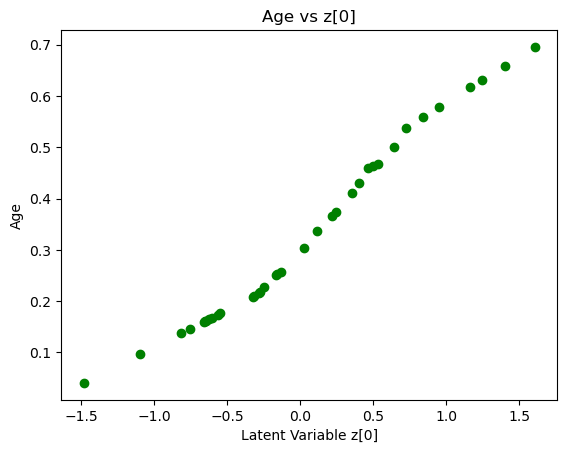

In [23]:
# plotting
plt.title("Age vs z[0]")
plt.xlabel("Latent Variable z[0]")
plt.ylabel("Age")
plt.scatter(x, y, color ="green")
plt.show()

In [12]:
pcd = o3d.io.read_triangle_mesh('C:/Users/Jakar/Downloads/Hippocampus_Study/generate_synthetic_data/torus_bump_500_three/torus_bump_248.ply')

In [89]:
pcd = o3d.io.read_triangle_mesh('C:/Users/Jakar/Downloads/Hippocampus_Study/generate_synthetic_data/groomed_data/after_alignment/torus_bump_200.ply')

In [11]:
pcd = o3d.io.read_triangle_mesh('C:/Users/Jakar/Downloads/Hippocampus_Study/train_data-20230521T160833Z-001/train_data/ab300_038.ply')

In [23]:
pcd = o3d.io.read_triangle_mesh('C:/Users/Jakar/Downloads/Hippocampus_Study/generate_synthetic_data/torus_bump_500_two_scale_binary_bump_variable/torus_bump_003.ply')

In [10]:
pcd = o3d.io.read_triangle_mesh('C:/Users/Jakar/Downloads/Hippocampus_Study/generate_synthetic_data/testing/torus_bump_0.ply')

[Open3D WARNING] Read PLY failed: unable to open file: C:/Users/Jakar/Downloads/Hippocampus_Study/generate_synthetic_data/testing/torus_bump_0.ply


In [15]:
pcd_no_reg_1 = o3d.io.read_triangle_mesh('C:/Users/Jakar/Downloads/Hippocampus_Study/disease_progression/groomed_data/after_alignment/ab300_100.ply')

In [16]:
pcd_no_reg_2 = o3d.io.read_triangle_mesh('C:/Users/Jakar/Downloads/Hippocampus_Study/disease_progression/groomed_data/after_alignment/tle_026.ply')

In [10]:
pcd_temp = o3d.io.read_triangle_mesh('C:/Users/Jakar/Downloads/Hippocampus_Study/disease_progression/reg_template/DeterministicAtlas__EstimatedParameters__Template_hippo.ply')

In [11]:
pcd_fl1 = o3d.io.read_triangle_mesh('C:/Users/Jakar/Downloads/Hippocampus_Study/disease_progression/hippoData_regstrd_disease_reconstrct_ply/DeterministicAtlas__Reconstruction__hippo__subject_ab300_200.ply')

In [12]:
pcd_medoid = o3d.io.read_triangle_mesh('C:/Users/Jakar/Downloads/Hippocampus_Study/disease_progression/whole_roi_3d_test/groomed_data/to_be_added_align_and_register/groomed_data/reference_medoid_shape/tle_012.ply')

In [13]:
pcd_fl2 = o3d.io.read_triangle_mesh('C:\\Users\\Jakar\\Downloads\\Hippocampus_Study\\disease_progression\\whole_roi_3d_test\\Extra_tle_registered_predicted\\ply_files\\DeterministicAtlas__Reconstruction__hippo__subject_TLE_005.ply')

In [24]:
pcd.compute_vertex_normals()
pcd.paint_uniform_color([0.8, 0.8, 0.8])

pcd_temp.compute_vertex_normals()
pcd_temp.paint_uniform_color([0.8, 0.8, 0.8])

pcd_no_reg_1.compute_vertex_normals()
pcd_no_reg_1.paint_uniform_color([0.8, 0.8, 0.8])

pcd_no_reg_2.compute_vertex_normals()
pcd_no_reg_2.paint_uniform_color([0.0, 0.8, 0.0])

pcd_fl2.compute_vertex_normals()
pcd_fl2.paint_uniform_color([0.0, 0.8, 0.0])

pcd_medoid.compute_vertex_normals()
pcd_medoid.paint_uniform_color([0.0, 0.8, 0.0])

o3d.visualization.draw_geometries([pcd])

In [49]:
pcd = o3d.io.read_triangle_mesh("C:\\Users\\Jakar\\Downloads\\Hippocampus_Study\\disease_progression\\reg_template\\DeterministicAtlas__EstimatedParameters__Template_hippo.ply")
pcd.compute_vertex_normals()
pcd.paint_uniform_color([0.8, 0.8, 0.8])
o3d.visualization.draw_geometries([pcd])

In [44]:
#print(np.min(pcd.vertices), np.max(pcd.vertices))
print('Vertices:')
print(np.asarray(pcd.vertices).shape)
print('Triangles:')
print(np.asarray(pcd.triangles).shape)
max_values = np.amax(pcd.vertices, axis=0)
min_values = np.amin(pcd.vertices, axis=0)

print("Maximum values:", max_values)
print("Minimum values:", min_values)

Vertices:
(6378, 3)
Triangles:
(12752, 3)
Maximum values: [0.5        0.36883196 0.10559965]
Minimum values: [-0.5        -0.36883196 -0.10559965]


In [50]:
#print(np.min(pcd.vertices), np.max(pcd.vertices))
print('Vertices:')
print(np.asarray(pcd.vertices).shape)
print('Triangles:')
print(np.asarray(pcd.triangles).shape)

max_values = np.amax(pcd.vertices, axis=0)
min_values = np.amin(pcd.vertices, axis=0)

print("Maximum values:", max_values)
print("Minimum values:", min_values)

Vertices:
(6378, 3)
Triangles:
(12752, 3)
Maximum values: [0.50031286 0.34880391 0.09214524]
Minimum values: [-0.49410915 -0.33976576 -0.08663015]


In [113]:
#print(np.min(pcd.vertices), np.max(pcd.vertices))
#print('Vertices:')
#print(np.asarray(pcd_fl1.vertices))
#print('Triangles:')
#print(np.asarray(pcd.triangles))
print(np.shape(np.asarray(pcd_fl2.vertices)))

(6378, 3)


In [496]:
pcd.compute_vertex_normals()
pcd.paint_uniform_color([0.8, 0.8, 0.8])
o3d.visualization.draw_geometries([pcd])

In [98]:
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the torus shape with bump
vertices = np.asarray(pcd.vertices)
faces = print(np.asarray(pcd.triangles))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=faces)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [ ]:
x_coords = np.linspace(-1, 1, 50)
y_coords = np.linspace(-1, 1, 50)
z_coords = np.linspace(-1, 1, 50)
x = np.stack(np.meshgrid(x_coords, y_coords, z_coords))

In [ ]:
x.shape

In [ ]:
def _length(a):
    return np.linalg.norm(a, axis=0)

In [ ]:
def sdf_torus(x, radius, thickness):
    q = np.stack([np.linalg.norm(x[[0, 2]], axis=0) - radius, x[1]])
    return np.linalg.norm(q, axis=0) - thickness

In [ ]:
_min = np.minimum
_max = np.maximum

In [ ]:
def sdf_box(x):
    q = np.abs(x) -1
    print(q.shape)
    return _length(_max(q, 0)) + _min(np.amax(q, axis=0), 1)

In [ ]:
def sdf_box2(x):
    q = np.abs(x)-1.5
    print(q.shape)
    return _length(_max(q, 0)) + _min(np.amax(q, axis=0), 1)

In [ ]:
sdf = sdf_box(x)

In [ ]:
sdf.shape

In [ ]:
verts, faces, normals, values = measure.marching_cubes(sdf)
verts = verts - 24.5
verts = verts / 12.5

In [ ]:
mp.plot(v=verts, f=faces)

In [ ]:
from scipy.spatial import distance
scale = []
distances = []
center = np.array([0,0,1])

for i in range(verts.shape[0]):
    
    dist = distance.euclidean(center, verts[i])
    
    if dist < 0.3:
        scale.append(True)
        distances.append(dist)
    else:
        scale.append(False)
        #distances.append(dist)



In [ ]:
len(distances)

In [ ]:
scale_indices = np.nonzero(np.array(scale))[0]

In [ ]:
scale_indices.shape

In [ ]:
scale_indices

In [ ]:
scale_verts = verts[scale_indices]

In [ ]:
scale_verts

In [ ]:
new_verts = []
for i in range(scale_verts.shape[0]):
    factor = 5 * np.exp(-distances[i]/0.1)
    new_verts.append(factor*verts[scale_indices][i][2])
    

In [ ]:
new_verts

In [ ]:
x_dist = np.linalg.norm((x - gaussian_center[:, None, None, None]), axis=0)
print(x_dist.shape)
x_bump = bump_height * np.e ** -(1. / bump_width * x_dist ** 2)

In [ ]:
keep_indices = np.nonzero(np.array(keep))[0]

x = np.asarray(box_with_bump.points)[:,0]
y = np.asarray(box_with_bump.points)[:,1]
z = np.asarray(box_with_bump.points)[:,2]

x = x[keep_indices]
y = y[keep_indices]
z = z[keep_indices]

box_with_bump.points = o3d.utility.Vector3dVector(np.stack([x, y, z], axis=1))
box_with_bump.estimate_normals()
o3d.visualization.draw_geometries([box_with_bump], point_show_normal=True)

In [ ]:
df = pd.DataFrame(verts, columns=["x", "y", "z"])
df.describe()

In [ ]:
df[(df.x == 24) & (df.y == 25) & (df.z == 24)]

In [ ]:
pd.DataFrame(verts).plot.hist()

In [ ]:
verts.shape

In [ ]:
verts[1000] = verts[1000]+20

In [ ]:
mp.plot(v=verts, f=faces)

In [ ]:
pcd = o3d.io.read_point_cloud('my_pts.ply')

In [ ]:
coords = np.linspace(-1, 1, 100)
x = np.stack(np.meshgrid(coords, coords, coords))

In [ ]:
x.shape(axis=0)

In [ ]:
q = np.stack([np.linalg.norm(x[[0, 1]], axis=0) - radius, x[2]])
return np.linalg.norm(q, axis=0) - thickness

In [ ]:
x[[0, 1]].shape

In [5]:
labels = torch.load("C:/Users/Jakar/Downloads/Hippocampus_Study/torus_bump_500/torus_bump_500/labels.pt") 

In [123]:
#labels

In [117]:
def f(x):
    return x

interact(f, x=10);

In [3]:
df = pd.read_excel('TLE.xlsx')
# Find the lowest age
lowest_age = df['Age'].min()

# Find the highest age
highest_age = df['Age'].max()

print(f"Lowest Age: {lowest_age}")
print(f"Highest Age: {highest_age}")

Lowest Age: 18.095890410958905
Highest Age: 73.2986301369863


In [4]:
df = pd.read_excel('TLE.xlsx')

# Drop rows with missing values in the second column
df.dropna(subset=[df.columns[1]], inplace=True)

# Create a dictionary using the first column as keys and the second column as values
dictionary = dict(zip(df[df.columns[0]].str[:2].str.lower() + df[df.columns[0]].str[2:], df[df.columns[1]]))

In [5]:
# Find the common keys
common_keys = set(hippo_labels.keys()).intersection(dictionary.keys())

# Create a dictionary with common keys and their corresponding values as arrays
result_dict = {key: [hippo_labels[key], dictionary[key]] for key in common_keys}

# Output the result dictionary
l = len(result_dict)

NameError: name 'hippo_labels' is not defined

In [6]:
# Define the range of ages
min_age = 5
max_age = 90

# Create a new dictionary to store the normalized values
normalized_data = {}

# Normalize each value and store it in the new dictionary
for key, value in dictionary.items():
    normalized_value = (value - min_age) / (max_age - min_age)
    normalized_data[key] = normalized_value

# Print the normalized dictionary
print(normalized_data)

{'tlE002': 0.4975987107171636, 'tlE002_2': 0.531248992747784, 'tlE003': 0.18643029814665593, 'tlE004': 0.2706526994359387, 'tlE005': 0.31803384367445603, 'tlE006': 0.44786462530217563, 'tlE007': 0.7718936341659952, 'tlE007_2': 0.8035132957292507, 'tlE008': 0.6343593875906527, 'tlE008_2': 0.6648186946011282, 'tlE009': 0.5728928283642224, 'tlE010': 0.49276390008058013, 'tlE010_2': 0.5227397260273973, 'tlE013': 0.6499274778404512, 'tlE017': 0.5214826752618856, 'tlE017_2': 0.5500725221595488, 'tlE018': 0.5381466559226431, 'tlE018_2': 0.5672199838839646, 'tlE019': 0.15406929895245772, 'tlE021': 0.5823690572119259, 'tlE021_2': 0.6111200644641418, 'tlE024': 0.3694762288477034, 'tlE024_2': 0.3974536663980661, 'tlE032': 0.3437872683319903, 'tlE032_2': 0.3715068493150685, 'tlE034': 0.5400161160354553, 'tlE040': 0.282610797743755, 'tlE040_2': 0.30978243352135376, 'tlE041': 0.5641901692183723, 'tlE041_2': 0.6055439161966156, 'tlE042': 0.34520547945205476, 'tlE043': 0.4648831587429492, 'tlE043_2': 

In [7]:
# Find the lowest and highest normalized values
lowest_normalized_value = min(normalized_data.values())
highest_normalized_value = max(normalized_data.values())

# Print the normalized dictionary and the lowest/highest values
print("Normalized Dictionary:", normalized_data)
print(f"Lowest Normalized Value: {lowest_normalized_value}")
print(f"Highest Normalized Value: {highest_normalized_value}")

Normalized Dictionary: {'tlE002': 0.4975987107171636, 'tlE002_2': 0.531248992747784, 'tlE003': 0.18643029814665593, 'tlE004': 0.2706526994359387, 'tlE005': 0.31803384367445603, 'tlE006': 0.44786462530217563, 'tlE007': 0.7718936341659952, 'tlE007_2': 0.8035132957292507, 'tlE008': 0.6343593875906527, 'tlE008_2': 0.6648186946011282, 'tlE009': 0.5728928283642224, 'tlE010': 0.49276390008058013, 'tlE010_2': 0.5227397260273973, 'tlE013': 0.6499274778404512, 'tlE017': 0.5214826752618856, 'tlE017_2': 0.5500725221595488, 'tlE018': 0.5381466559226431, 'tlE018_2': 0.5672199838839646, 'tlE019': 0.15406929895245772, 'tlE021': 0.5823690572119259, 'tlE021_2': 0.6111200644641418, 'tlE024': 0.3694762288477034, 'tlE024_2': 0.3974536663980661, 'tlE032': 0.3437872683319903, 'tlE032_2': 0.3715068493150685, 'tlE034': 0.5400161160354553, 'tlE040': 0.282610797743755, 'tlE040_2': 0.30978243352135376, 'tlE041': 0.5641901692183723, 'tlE041_2': 0.6055439161966156, 'tlE042': 0.34520547945205476, 'tlE043': 0.4648831

In [ ]:
hippo_labels

In [13]:
# Filter values greater than 0.15406 and less than 0.80351
filtered_values = {key: value for key, value in hippo_labels.items() if 0.15406 < value < 0.80351}

# Display the filtered values
print(len(filtered_values))

337


In [15]:
output_dict={}
for key, value in normalized_data.items():
    if key.startswith('tlE'):
        new_key = 'tle_' + key[3:]
        output_dict[new_key] = value
    else:
        output_dict[key] = value

print(len(output_dict))

43


In [21]:
# Assuming your original dictionary is called 'your_dictionary'
new_dictionary = {}

for key, value in normalized_data.items():
    new_key = key.lower()  # Convert the key to lowercase
    new_dictionary[new_key] = value  # Update the new dictionary with lowercase key

# new_dictionary now contains lowercase keys
print(len(new_dictionary))

43


In [17]:
hippo_all_tle = {**filtered_values, **output_dict}
len(hippo_all_tle)
#print(hippo_all_ms)

380

In [18]:
# Assuming your original dictionary is called 'your_dictionary'
new_dictionary = {}

for idx, (key, age) in enumerate(hippo_all_tle.items()):
    if idx >= len(hippo_all_tle) - 43:
        new_dictionary[key] = np.array([age, 1])
    else:
        new_dictionary[key] = np.array([age, 0])


In [19]:
len(new_dictionary)

380

In [20]:
print(new_dictionary)

{'ab300_001': array([0.34117647, 0.        ]), 'ab300_002': array([0.30588235, 0.        ]), 'ab300_003': array([0.41176471, 0.        ]), 'ab300_004': array([0.56470588, 0.        ]), 'ab300_005': array([0.16470588, 0.        ]), 'ab300_006': array([0.18823529, 0.        ]), 'ab300_007': array([0.61176471, 0.        ]), 'ab300_008': array([0.32941176, 0.        ]), 'ab300_009': array([0.70588235, 0.        ]), 'ab300_010': array([0.35294118, 0.        ]), 'ab300_011': array([0.72941176, 0.        ]), 'ab300_012': array([0.22352941, 0.        ]), 'ab300_014': array([0.16470588, 0.        ]), 'ab300_015': array([0.34117647, 0.        ]), 'ab300_016': array([0.62352941, 0.        ]), 'ab300_017': array([0.28235294, 0.        ]), 'ab300_018': array([0.2, 0. ]), 'ab300_019': array([0.2, 0. ]), 'ab300_020': array([0.2, 0. ]), 'ab300_021': array([0.56470588, 0.        ]), 'ab300_022': array([0.63529412, 0.        ]), 'ab300_023': array([0.28235294, 0.        ]), 'ab300_024': array([0.4235294

In [21]:
torch.save(new_dictionary, "C:\\Users\\Jakar\\Downloads\\Hippocampus_Study\\disease_progression\\hippo_tle_label_age_18_73\\labels.pt")

#pd.DataFrame(list(labels.items()), columns=['shape', 'label']).to_csv("torus_bump\\torus_bump_labels.csv")

# Create an empty DataFrame
df = pd.DataFrame(columns=['id', 'age', 'is_disease'])

# Iterate over the items in the labels dictionary
for ids, values in new_dictionary.items():
    # Access the individual values from the NumPy array
    value1 = values[0]
    value2 = values[1]

    # Append a new row with the values to the DataFrame
    df = df.append({'id': ids, 'age': value1, 'is_disease': value2}, ignore_index=True)

# Write the DataFrame to an Excel file
df.to_csv("C:\\Users\\Jakar\\Downloads\\Hippocampus_Study\\disease_progression\\hippo_tle_label_age_18_73\\hippo_score_labels.csv")

In [35]:
import torch
from sklearn.model_selection import train_test_split

# Load labels
labels = torch.load("/home/jakaria/Explaining_Shape_Variability/src/DeepLearning/compute_canada/guided_vae/data/CoMA/raw/hippocampus/labels.pt")
#labels = torch.load("C:\\Users\\Jakar\\Downloads\\Hippocampus_Study\\disease_progression\\hippo_ms_label_age_32_71\\labels.pt")
# Filter keys starting with "ms"
ms_keys = [key for key in labels.keys() if key.startswith("ms")]

# Split ms_keys into training, validation, and test sets
ms_train, ms_test = train_test_split(ms_keys, test_size=0.2, random_state=28)
ms_val, ms_test = train_test_split(ms_test, test_size=0.5, random_state=28)

# Get non-"ms" keys
non_ms_keys = [key for key in labels.keys() if not key.startswith("ms")]

# Split non-ms_keys into training, validation, and test sets
X_train, X_test = train_test_split(non_ms_keys, test_size=0.2, random_state=28)
X_val, X_test = train_test_split(X_test, test_size=0.5, random_state=28)

# Combine the splits
X_train.extend(ms_train)
X_val.extend(ms_val)
X_test.extend(ms_test)

# Create corresponding labels for the splits
y_train = [labels[key] for key in X_train]
y_val = [labels[key] for key in X_val]
y_test = [labels[key] for key in X_test]


In [39]:
print(y_train)

[array([0.37647059, 0.        ]), array([0.71764706, 0.        ]), array([0.64705882, 0.        ]), array([0.71764706, 0.        ]), array([0.62352941, 0.        ]), array([0.35294118, 0.        ]), array([0.62352941, 0.        ]), array([0.70588235, 0.        ]), array([0.51764706, 0.        ]), array([0.55294118, 0.        ]), array([0.37647059, 0.        ]), array([0.61176471, 0.        ]), array([0.36470588, 0.        ]), array([0.37647059, 0.        ]), array([0.57647059, 0.        ]), array([0.31764706, 0.        ]), array([0.77647059, 0.        ]), array([0.65882353, 0.        ]), array([0.38823529, 0.        ]), array([0.51764706, 0.        ]), array([0.75294118, 0.        ]), array([0.63529412, 0.        ]), array([0.35294118, 0.        ]), array([0.37647059, 0.        ]), array([0.56470588, 0.        ]), array([0.50588235, 0.        ]), array([0.47058824, 0.        ]), array([0.62352941, 0.        ]), array([0.44705882, 0.        ]), array([0.61176471, 0.        ]), array([0.

In [22]:
labels = torch.load("C:\\Users\\Jakar\\Downloads\\Hippocampus_Study\\disease_progression\\hippo_tle_label_age_18_73\\labels.pt")

In [23]:
labels

{'ab300_001': array([0.34117647, 0.        ]),
 'ab300_002': array([0.30588235, 0.        ]),
 'ab300_003': array([0.41176471, 0.        ]),
 'ab300_004': array([0.56470588, 0.        ]),
 'ab300_005': array([0.16470588, 0.        ]),
 'ab300_006': array([0.18823529, 0.        ]),
 'ab300_007': array([0.61176471, 0.        ]),
 'ab300_008': array([0.32941176, 0.        ]),
 'ab300_009': array([0.70588235, 0.        ]),
 'ab300_010': array([0.35294118, 0.        ]),
 'ab300_011': array([0.72941176, 0.        ]),
 'ab300_012': array([0.22352941, 0.        ]),
 'ab300_014': array([0.16470588, 0.        ]),
 'ab300_015': array([0.34117647, 0.        ]),
 'ab300_016': array([0.62352941, 0.        ]),
 'ab300_017': array([0.28235294, 0.        ]),
 'ab300_018': array([0.2, 0. ]),
 'ab300_019': array([0.2, 0. ]),
 'ab300_020': array([0.2, 0. ]),
 'ab300_021': array([0.56470588, 0.        ]),
 'ab300_022': array([0.63529412, 0.        ]),
 'ab300_023': array([0.28235294, 0.        ]),
 'ab300_

In [ ]:
torch.save(result_dict, "new_labels_cognitive_score_hippo/labels.pt")

#pd.DataFrame(list(labels.items()), columns=['shape', 'label']).to_csv("torus_bump\\torus_bump_labels.csv")

# Create an empty DataFrame
df = pd.DataFrame(columns=['shape', 'age', 'PSMT_score'])

# Iterate over the items in the labels dictionary
for shape, values in result_dict.items():
    # Access the individual values from the NumPy array
    value1 = values[0]
    value2 = values[1]

    # Append a new row with the values to the DataFrame
    df = df.append({'shape': shape, 'age': value1, 'PSMT_score': value2}, ignore_index=True)

# Write the DataFrame to an Excel file
df.to_csv("new_labels_cognitive_score_hippo/hippo_score_labels.csv")

In [119]:
test = torch.load("C:\\Users\\Jakar\\Downloads\\Hippocampus_Study\\disease_progression\\hippo_tle_label\\labels.pt")

In [20]:
test

NameError: name 'test' is not defined

In [104]:
# Find the maximum and minimum values of the second element
min_val = min(test.values(), key=lambda x: x[1])[1]
max_val = max(test.values(), key=lambda x: x[1])[1]

# Normalize the second element of each array
for key in test:
    value = test[key]
    normalized_value = (value[1] - min_val) / (max_val - min_val)
    value[1] = normalized_value

#print(test)

In [ ]:
result_dict = test
torch.save(result_dict, "new_labels_cognitive_score_hippo/labels.pt")

#pd.DataFrame(list(labels.items()), columns=['shape', 'label']).to_csv("torus_bump\\torus_bump_labels.csv")

# Create an empty DataFrame
df = pd.DataFrame(columns=['shape', 'age', 'PSMT_score'])

# Iterate over the items in the labels dictionary
for shape, values in result_dict.items():
    # Access the individual values from the NumPy array
    value1 = values[0]
    value2 = values[1]

    # Append a new row with the values to the DataFrame
    df = df.append({'shape': shape, 'age': value1, 'PSMT_score': value2}, ignore_index=True)

# Write the DataFrame to an Excel file
df.to_csv("new_labels_cognitive_score_hippo/hippo_score_labels.csv")

In [19]:
angles_predict = torch.load("C:/Users/Jakar/Downloads/Hippocampus_Study/generate_synthetic_data/models_torus/170/angles_predict.pt", map_location=torch.device('cpu')) 

In [ ]:
angles_predict*360.0

In [20]:
mesh_predict_np_t = np.load('C:/Users/Jakar/Downloads/Hippocampus_Study/generate_synthetic_data/models_torus/170/mesh_predict.npy')
mesh_predict_t = mesh_predict_np_t.tolist()

In [21]:
verts = np.array(mesh_predict_t[-4]).squeeze()
verts.shape

(3496, 3)

In [22]:
pcd1 = o3d.io.read_triangle_mesh('C:/Users/Jakar/Downloads/Hippocampus_Study/generate_synthetic_data/torus_bump_500_one/template.ply')

In [23]:
faces = np.asarray(pcd1.triangles)
faces.shape

(6992, 3)

In [201]:
#######################################################
igl.write_triangle_mesh("C:/Users/Jakar/Downloads/Hippocampus_Study/generate_synthetic_data/models_torus/170/generated_0.ply", verts, faces)

True

In [202]:
pcd1 = o3d.io.read_triangle_mesh('C:/Users/Jakar/Downloads/Hippocampus_Study/generate_synthetic_data/models_torus/170/generated_0.ply')

In [24]:
pcd1.compute_vertex_normals()
pcd1.paint_uniform_color([0.8, 0.8, 0.8])
o3d.visualization.draw_geometries([pcd1])

In [405]:
z = torch.zeros(16)
@interact(**{f'z{i}': FloatSlider(min=-3.0, max=3.0, step=0.2, value=0) for i in range(16)})
def update_array(**kwargs):
    global z
    z = torch.tensor([kwargs[f'z{i}'] for i in range(16)])
    return z

interactive(children=(FloatSlider(value=0.0, description='z0', max=3.0, min=-3.0, step=0.2), FloatSlider(value…

In [ ]:
tensor = torch.rand((50, 1))
tensor

In [ ]:
tensor[0:5]

In [421]:
#z

In [ ]:
import os

# Define the directory path
directory_path = "C:\\Users\Jakar\\Downloads\\Hippocampus_Study\\disease_progression\\hippoData_regstrd_disease_reconstrct_ply"

# Define the common prefix to remove
common_prefix = "DeterministicAtlas__Reconstruction__hippo__subject_"

# List all files in the directory
file_list = os.listdir(directory_path)

# Iterate through the files
for filename in file_list:
    # Check if the file starts with the common prefix
    if filename.startswith(common_prefix):
        # Extract the remaining part and convert it to lowercase
        new_name = filename[len(common_prefix):].lower()
        
        # Construct the new file path
        new_path = os.path.join(directory_path, new_name)
        
        # Rename the file
        os.rename(os.path.join(directory_path, filename), new_path)
        
        print(f"Renamed '{filename}' to '{new_name}'")


In [41]:
# Load the vertices and faces from the .npy files
faces_all = np.load("C:\\Users\\Jakar\\Downloads\\Hippocampus_Study\\disease_progression\\save_plots_ms_range\\mesh_faces.npy")
vertices_all = np.load("C:\\Users\\Jakar\\Downloads\\Hippocampus_Study\\disease_progression\\save_plots_ms_range\\mesh_vertices.npy")

In [42]:
print(vertices_all.shape)
print(faces_all.shape[0])

(16, 6378, 3)
16


In [47]:
import open3d.visualization as vis
from matplotlib.colors import LinearSegmentedColormap

j=1
for i in range(0, vertices_all.shape[0], 2):
    
    mesh2_vertices = vertices_all[i]
    mesh2_faces = faces_all[i]
    mesh1_vertices = vertices_all[i+1]
    mesh1_faces = faces_all[i+1]

    # Calculate the distances between corresponding vertices 
    distances = np.linalg.norm(mesh1_vertices - mesh2_vertices, axis=1)

    # Add a small epsilon value to the denominator to avoid division by zero
    epsilon = 1e-6
    normalized_distances = (distances - distances.min()) / (distances.max() - distances.min() + epsilon)

    # Replace NaN values with a specific value (e.g., 0.5 for gray)
    normalized_distances[np.isnan(normalized_distances)] = 0.5

    # Create Open3D TriangleMesh objects for both meshes
    mesh1 = o3d.geometry.TriangleMesh()
    mesh1.vertices = o3d.utility.Vector3dVector(mesh1_vertices)
    mesh1.triangles = o3d.utility.Vector3iVector(mesh1_faces)

    mesh2 = o3d.geometry.TriangleMesh()
    mesh2.vertices = o3d.utility.Vector3dVector(mesh2_vertices)
    mesh2.triangles = o3d.utility.Vector3iVector(mesh2_faces)

    '''
    def distance_to_color(distance):
        if distance == 0:
            return [0, 0, 0.5]  # Dark blue for no distance
        elif distance < 0.1:
            return [0, 0, 1]  # Solid blue for very low distances
        elif distance < 0.2:
            return [0.5, 0.5, 1]  # Light blue for low distances
        elif distance < 0.4:
            return [1, 1, 0.5]  # Light yellow for distances in [0.2, 0.4)
        else:
            return [1, 1, 0]  # Solid yellow for distances greater than or equal to 0.4


    # Map the distances to colors
    colors = [distance_to_color(distance) for distance in normalized_distances]
    '''

    # Define a custom colormap that transitions from dark blue to light blue to light yellow to dark yellow
    colors = [(0, 0, 0.5), (0.5, 0.5, 1), (1, 1, 0.5), (1, 1, 0)]
    n_bins = 100  # Number of bins in the colormap
    cmap_name = "custom_cmap"
    custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    # Map the normalized distances to colors using the custom colormap
    colors = custom_cmap(normalized_distances)

    # Create a blank VertexColors object and set it with colors
    mesh1.vertex_colors = o3d.utility.Vector3dVector(np.zeros_like(mesh2_vertices, dtype=float))
    for i, color in enumerate(colors):
        mesh1.vertex_colors[i] = color[:3]  # Assign RGB color to each vertex


    mesh1.compute_vertex_normals()
    mesh2.compute_vertex_normals()
    mesh2.paint_uniform_color([0, 0, 0.5])

    # Visualize the colored mesh2
    #o3d.visualization.draw_geometries([mesh1])
    o3d.visualization.draw_geometries([mesh2])
    #o3d.visualization.draw_geometries([mesh1, mesh2], window_name='Meshes', width=800, height=800)
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(mesh1)
    vis.update_geometry(mesh1)
    vis.poll_events()
    vis.update_renderer()
    vis.capture_screen_image(f"C:\\Users\\Jakar\\Downloads\\Hippocampus_Study\\disease_progression\\save_plots\\save_plots\\{j}_diseased.png")
    vis.destroy_window()
    #mesh2
    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(mesh2)
    vis.update_geometry(mesh2)
    vis.poll_events()
    vis.update_renderer()
    vis.capture_screen_image(f"C:\\Users\\Jakar\\Downloads\\Hippocampus_Study\\disease_progression\\save_plots\\save_plots\\{j}_healthy.png")
    vis.destroy_window()
    j=j+1
    #if j == 2:
        #break

In [76]:
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(mesh1)
vis.update_geometry(mesh1)
vis.poll_events()
vis.update_renderer()
vis.capture_screen_image("C:\\Users\\Jakar\\Downloads\\Hippocampus_Study\\disease_progression\\save_plots\\save_plots\\1.png")
vis.destroy_window()

In [16]:
print(np.max(distances))

0.014296832195129387


C:\Users\Jakar\AppData\Local\Temp\ipykernel_32908\2234274258.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(['0', '1', '2', '3', '4'])


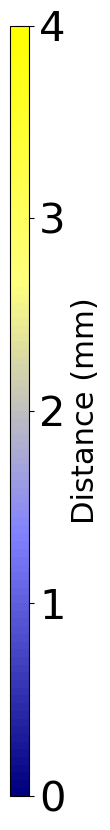

In [36]:
# Create a Matplotlib figure for the color bar
fig_colorbar = plt.figure(figsize=(0.25, 10))  # Adjust the figure size as needed

# Create the color bar using Matplotlib
colorbar_ax = fig_colorbar.add_subplot(111)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=custom_cmap), cax=colorbar_ax, orientation='vertical')
cbar.set_label('Distance (mm)')# Set custom ticks for the color bar
ticks = np.linspace(0, 1, num=5)  # Customize the tick positions (0 to 1 in this example)
cbar.set_ticklabels(['0', '1', '2', '3', '4']) 
cbar.set_ticks(ticks)

cbar.ax.tick_params(axis='y', labelsize=30)  # Set the font size of the tick labels
cbar.ax.set_ylabel(cbar.ax.get_ylabel(), fontsize=22)  # Set the font size of the color bar label

# Display the color bar
plt.show()

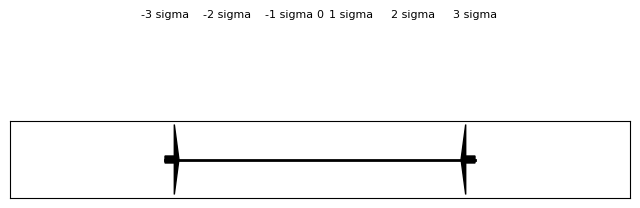

In [42]:
print(mesh1_vertices.shape)

(6378, 3)


In [35]:
white_color = [1.0, 1.0, 1.0]
grey_color = [0.5, 0.5, 0.5]

mp.plot(vertices_all[0], faces_all[0], c=np.array(white_color), return_plot=True)
#mp.plot(vertices_all[1], faces_all[1], return_plot=True)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.004293…

In [48]:
import cv2
import os

# Define input and output directories
input_directory = "C:\\Users\\Jakar\\Downloads\\Hippocampus_Study\\disease_progression\\save_plots\\save_plots\\"
output_directory = "C:\\Users\\Jakar\\Downloads\\Hippocampus_Study\\disease_progression\\save_plots_ms_range\\"

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Specify the number of pixels to crop from each side
left_crop = 550
right_crop = 550
top_crop = 250
bottom_crop = 240

# Loop through the images in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith((".jpg", ".jpeg", ".png", ".bmp")):
        # Read the image
        image = cv2.imread(os.path.join(input_directory, filename))

        if image is not None:
            # Get the original dimensions
            original_height, original_width = image.shape[:2]
            #print(original_height, original_width)
            
            # Calculate the cropping dimensions
            crop_x1 = left_crop
            crop_x2 = original_width - right_crop
            crop_y1 = top_crop
            crop_y2 = original_height - bottom_crop

            # Crop the image
            cropped_image = image[crop_y1:crop_y2, crop_x1:crop_x2]

            # Save the cropped image to the output directory
            output_filename = os.path.join(output_directory, filename)
            cv2.imwrite(output_filename, cropped_image)

            # Display original and cropped dimensions
            print(f"Original Dimensions: {original_width}x{original_height}")
            cropped_width, cropped_height = cropped_image.shape[:2]
            print(f"Cropped Dimensions: {cropped_width}x{cropped_height}\n")
        else:
            print(f"Unable to read image: {filename}")

Original Dimensions: 1920x1053
Cropped Dimensions: 563x820

Original Dimensions: 1920x1053
Cropped Dimensions: 563x820

Original Dimensions: 1920x1053
Cropped Dimensions: 563x820

Original Dimensions: 1920x1053
Cropped Dimensions: 563x820

Original Dimensions: 1920x1053
Cropped Dimensions: 563x820

Original Dimensions: 1920x1053
Cropped Dimensions: 563x820

Original Dimensions: 1920x1053
Cropped Dimensions: 563x820

Original Dimensions: 1920x1053
Cropped Dimensions: 563x820

Original Dimensions: 1920x1053
Cropped Dimensions: 563x820

Original Dimensions: 1920x1053
Cropped Dimensions: 563x820

Original Dimensions: 1920x1053
Cropped Dimensions: 563x820

Original Dimensions: 1920x1053
Cropped Dimensions: 563x820

Original Dimensions: 1920x1053
Cropped Dimensions: 563x820

Original Dimensions: 1920x1053
Cropped Dimensions: 563x820

Original Dimensions: 1920x1053
Cropped Dimensions: 563x820

Original Dimensions: 1920x1053
Cropped Dimensions: 563x820



In [2]:
import numpy as np

A = np.array([8200, 8510, 8800, 9205, 9595, 8200, 8510, 8800, 9205, 9595, 8200, 8510, 8800, 9205, 9595, 8520, 8825, 9240, 9522, 9810])
B = np.array([8520, 8825, 9240, 9522, 9810, 8520, 8825, 9240, 9522, 9810,8520, 8825, 9240, 9522, 9810, 8520, 8825, 9240, 9522, 9810])

mean_A = np.mean(A)
std_dev_A = np.std(A)

mean_B = np.mean(B)
std_dev_B = np.std(B)

print("Mean of A:", mean_A)
print("Standard Deviation of A:", std_dev_A)
print("Mean of B:", mean_B)
print("Standard Deviation of B:", std_dev_B)


Mean of A: 8942.35
Standard Deviation of A: 506.4182337752068
Mean of B: 9183.4
Standard Deviation of B: 464.5495022061697


In [3]:
ositive_differences = np.random.randint(200, 220, 10)

In [4]:
ositive_differences

array([211, 216, 219, 212, 205, 213, 205, 204, 219, 205])

In [5]:
from scipy.stats import ttest_1samp

w_stat, p_value = ttest_1samp(ositive_differences, 0)

print("Wilcoxon W-statistic:", w_stat)
print("P-value:", p_value)


Wilcoxon W-statistic: 112.74868987669332
P-value: 1.724288365974981e-15
